# DSBA 22/23 HSE & University of London

# Practical assignment 1. DL in classification.

## General info
Release data: 26.09.2022

Soft deadline: 10.10.2022 23:59 MSK

Hard deadline: 13.10.2021 23:59 MSK

In this task, you are to build a NN for a binary classification task. We suggest using Google Colab for access to GPU. Competition invite link: https://www.kaggle.com/t/1917e22edb71437ca24d790ab1d57695

## Evaluation and fines

Each section has a defined "value" (in brackets near the section). Maximum grade for the task - 10 points, other points can be assigned to your tests.

**Your notebook with the best solution must be reproducible should be sent to the dropbox!** If the assessor cannot reproduce your results, you may be assigned score = 0, so make all your computations fixed!

**You can only use neural networks / linear / nearest neighbors models for this task - tree-based models are forbidden!**

All the parts must be done independently.

After the hard deadline is passed, the hometask is not accepted. If you send the hometask after the soft deadline, you will be excluded from competition among your mates and the homework will only be scored by the "Beating the baseline" part.

Feel free to ask questions both the teacher and your mates, but __do not copy the code or do it together__. "Similar" solutions are considered a plagiarism and all the involved students (the ones who gave & the ones who did) cannot get more than 0.01 points for the task. If you found a solution in some open source, you __must__ reference it in a special block at the end of your work (to exclude the suspicions in plagiarism).


## Format of handing over

The tasks are sent to the dropbox: https://www.dropbox.com/request/Y6TJouxNbm3r0RgcBL35. Don't forget to attach your name, surname & your group.


## 1. Model training

**Important!** Public Leaderboard contains only 33% of the test data. Your points will be measured wrt to the whole test set, therefore your position on the LB after the end of the competition may change.

* test_accuracy > weak baseline (public LB): 3 points

* test_accuracy > medium baseline (public LB): + 3 points

* test_accuracy > strong baseline (public LB): + 2 points

* You are among 25% most successful students (private LB): + 2 point

* You are among top-3 most successful students (private LB): + 1 point

* You are among top-2 most successful students (private LB): + 1 point

* You are among top-1 most successful students (private LB): + 1 point

In [1]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [4]:
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [5]:
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# **Preprocessing data**

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
target_df = pd.read_csv('train_target.csv')
train_expected_target1 = pd.read_csv('train_expected_target_agent_1.csv')
train_expected_target2 = pd.read_csv('train_expected_target_agent_2.csv')
train_target_agent_1 = pd.read_csv('train_target_agent_1.csv')
train_target_agent_2 = pd.read_csv('train_target_agent_2.csv')

In [7]:
train_target_agent_1 = train_target_agent_1.rename(columns={"0": "expected_target1"})
train_target_agent_2 = train_target_agent_2.rename(columns={"0": "expected_target2"})

In [8]:
train_df = pd.concat([train_df, train_target_agent_1, train_target_agent_2], axis=1)

In [9]:
train_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,14.16,267.0,194.0,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,7.66,191.0,287.0,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,298.0,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,9.53,195.0,239.0,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,8.76,161.0,283.0,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2


In [10]:
test_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
0,58.6,87.0,15.2,6.83,0.844742,1.165049,9.19,16.50,337.0,179.0,...,2.661870,1.893116,4.241360,2.932115,2.690442,1.0,0.0,1.0,0.666667,0.333333
1,50.7,81.3,14.2,6.65,0.743218,1.152593,10.31,13.63,311.0,208.0,...,3.550724,2.373700,4.197010,3.373811,3.075302,0.0,1.0,1.0,0.666667,0.625000
2,47.3,81.4,17.7,6.73,0.954509,0.956938,14.21,11.82,207.0,270.0,...,2.693652,2.042668,0.966665,1.900995,3.007033,0.0,1.0,1.0,0.666667,0.555556
3,54.5,84.8,14.5,6.85,1.155612,1.049618,10.95,12.46,339.0,186.0,...,3.938100,1.466409,0.922046,2.108852,2.643923,1.0,0.0,0.0,0.333333,0.444444
4,51.3,81.8,16.4,6.81,1.199718,0.856327,11.27,11.52,193.0,293.0,...,3.358338,2.138405,1.872476,2.456406,3.113815,0.0,0.0,0.0,0.000000,0.555556


In [11]:
train_df.shape

(2470, 236)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Columns: 236 entries, agent_1_feat_Possession% to expected_target2
dtypes: float64(212), int64(24)
memory usage: 4.4 MB


In [13]:
target_df.drop('id', axis = 1, inplace = True)

In [14]:
train_df = pd.concat([target_df, train_df], axis = 1)

In [15]:
train_df

,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,1,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,14.16,267.0,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,7.66,191.0,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,0,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,9.53,195.0,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,1,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,8.76,161.0,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,1,41.6,76.0,17.1,6.62,1.046406,1.032989,18.00,8.27,138.0,...,3.684860,4.024907,3.872622,1.000000,0.000000,0.000000,0.333333,0.444444,1,2
2466,1,42.9,76.1,18.3,6.61,1.161802,1.066236,16.14,7.60,201.0,...,1.568175,2.000313,2.572016,0.000000,0.000000,0.000000,0.000000,0.444444,2,3
2467,0,41.0,72.2,19.1,6.51,1.000858,1.026472,15.99,7.99,164.0,...,3.871643,2.496854,2.555157,0.000000,0.000000,1.000000,0.333333,0.500000,0,5
2468,1,51.4,79.3,14.1,6.62,1.037986,1.161401,9.73,10.47,222.0,...,4.904164,2.977092,2.495116,1.000000,0.000000,0.000000,0.333333,0.222222,1,3


## Delete outliers

In [16]:
train_expected_target1 = train_expected_target1.rename(columns={"0": "train_expected_target1"})
train_expected_target2 = train_expected_target2.rename(columns={"0": "train_expected_target2"})
train_df = pd.concat([train_expected_target1, train_df], axis = 1)
train_df = pd.concat([train_expected_target2, train_df], axis = 1)
train_df.head()

,train_expected_target2,train_expected_target1,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,0.278076,1.166350,1,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,0.613273,1.278300,1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,1.117570,1.900670,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,0.909774,0.423368,0,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,0.991901,1.683430,1,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2


In [17]:
print('Rows before deleting: ', train_df.shape[0])
train_df = train_df.drop(train_df[(train_df.train_expected_target2 > 1) &
                                  (train_df.train_expected_target1 > 1) &
                                  (train_df.category == 0)].index)
train_df.drop(['train_expected_target1', 'train_expected_target2'], axis = 1, inplace = True)
print('Rows after deleting: ', train_df.shape[0])

Rows before deleting:  2470
Rows after deleting:  2295


## Work with missing variables

In [18]:
print('Rows before deleting: ', train_df.shape[0])
train_df = train_df.dropna()  
print('Rows after deleting: ', train_df.shape[0])

Rows before deleting:  2295
Rows after deleting:  2163


# Corr

In [19]:
train_df

,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
20,0,44.0,70.3,25.1,6.79,0.711201,0.915529,10.74,9.43,218.0,...,1.608046,2.112304,1.608046,0.578947,0.578947,1.0,0.719298,1.000000,0,0
21,0,57.0,84.6,15.9,7.07,1.094698,0.938272,7.57,13.92,575.0,...,2.479335,2.214160,2.479335,0.526316,0.526316,1.0,0.684211,1.000000,0,1
22,1,48.1,76.9,17.7,6.74,0.994530,1.235052,9.77,8.24,175.0,...,1.712261,2.183093,1.712261,0.526316,0.526316,1.0,0.684211,1.000000,3,3
23,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,...,2.675331,2.627794,2.675331,0.421053,0.421053,1.0,0.614035,1.000000,1,0
24,0,50.7,82.1,14.4,6.86,1.124694,0.875939,11.79,10.66,156.0,...,1.331644,2.260683,1.331644,0.368421,0.368421,0.0,0.245614,0.000000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,1,41.6,76.0,17.1,6.62,1.046406,1.032989,18.00,8.27,138.0,...,3.684860,4.024907,3.872622,1.000000,0.000000,0.0,0.333333,0.444444,1,2
2466,1,42.9,76.1,18.3,6.61,1.161802,1.066236,16.14,7.60,201.0,...,1.568175,2.000313,2.572016,0.000000,0.000000,0.0,0.000000,0.444444,2,3
2467,0,41.0,72.2,19.1,6.51,1.000858,1.026472,15.99,7.99,164.0,...,3.871643,2.496854,2.555157,0.000000,0.000000,1.0,0.333333,0.500000,0,5
2468,1,51.4,79.3,14.1,6.62,1.037986,1.161401,9.73,10.47,222.0,...,4.904164,2.977092,2.495116,1.000000,0.000000,0.0,0.333333,0.222222,1,3


In [20]:
corr_matrix1 = train_df.corr()
print(corr_matrix1["expected_target1"].sort_values(ascending=False))

expected_target1          1.000000
agent_1_feat_ScoredAv     0.385431
agent_1_feat_XgAv         0.360820
agent_1_feat_DC           0.341588
agent_1_feat_pl_median    0.328869
                            ...   
agent_1_feat_PPDA        -0.213783
agent_2_feat_Rating      -0.215384
agent_1_feat_MissedAv    -0.260551
agent_1_feat_XgaAv       -0.267009
agent_1_feat_ODC         -0.290223
Name: expected_target1, Length: 237, dtype: float64


In [21]:
corr_matrix2 = train_df.corr()
print(corr_matrix2["expected_target2"].sort_values(ascending=False))

expected_target2         1.000000
category                 0.471964
agent_2_feat_ScoredAv    0.335948
agent_2_feat_XgAv        0.324758
agent_2_feat_pl_mean     0.294398
                           ...   
agent_2_feat_MissedAv   -0.225085
agent_1_feat_pl_mean    -0.225340
agent_2_feat_XgaAv      -0.241378
agent_1_feat_Rating     -0.250496
agent_2_feat_ODC        -0.263211
Name: expected_target2, Length: 237, dtype: float64


## Split dataset on train and test

In [22]:
X = train_df.drop(['expected_target1','category','expected_target2'], axis=1)
Y_category = train_df['category']
Y_expected1 = train_df['expected_target1']
Y_expected2 = train_df['expected_target2']
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = (X.iloc[0:int(len(X)*0.8)], 
                                    X.iloc[int(len(X)*0.8):len(X)], 
                                    Y_expected1.iloc[0:int(len(Y_expected1)*0.8)], 
                                    Y_expected1.iloc[int(len(Y_expected1)*0.8):len(Y_expected1)],
                                    Y_expected2.iloc[0:int(len(Y_expected2)*0.8)], 
                                    Y_expected2.iloc[int(len(Y_expected2)*0.8):len(Y_expected2)])

In [23]:
X_train.shape, X_test.shape, y_train1.shape, y_test1.shape, y_train2.shape, y_test2.shape

((1730, 234), (433, 234), (1730,), (433,), (1730,), (433,))

## Scale data

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_df = scaler.transform(test_df)

# **Model**

In [24]:
def create_model(batch_size, epochs, num_classes, input_shape):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_shape=(input_shape, ))) # Hidden Layer 1
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation="relu")) # Hidden Layer 2
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation="relu")) # Hidden Layer 3
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation="relu")) # Hidden Layer 4
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation="relu")) # Hidden Layer 5
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(16, activation="relu")) # Hidden Layer 6
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
        
    model.add(Dense(num_classes, activation="softmax")) # Outout Layer
    
    sgd = SGD(learning_rate=0.0001, momentum=0.9)

    model.compile(optimizer=sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [25]:
def make_equal_dummies(y_train, y_test):
    dif = len(y_train.columns) - len(y_test.columns)
    if dif == 0:
        pass
    elif dif > 0:
        while dif != 0:
            y_test[int(y_test.columns[-1])+1] = 0
            dif -= 1
    else:
        while dif != 0:
            y_train[int(y_train.columns[-1])+1] = 0
            dif += 1
            
    print(y_test.shape, y_train.shape)
    return y_train, y_test

In [26]:
def make_graphs(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [27]:
def calc_train_acc(model, expected_target, Y_expected):
    tmp_real_value = train_df[expected_target][int(len(Y_expected)*0.8):len(Y_expected)]
    y_pred = model.predict(X_test)
    tmp_pred_value = []
    for i in y_pred:
        if i.argmax() != 0:
            tmp_pred_value.append(1)
        else:
            tmp_pred_value.append(0)
    
#     print(len(tmp_real_value), len(tmp_pred_value))
    num_matching = 0
    if len(tmp_real_value) == len(tmp_pred_value):
        for i, j in zip(tmp_real_value, tmp_pred_value):
            if i != 0:
                i = 1
            if i == j:
                num_matching += 1
        print("ACC: ", np.round((num_matching / len(tmp_real_value)), 3))
    else:
        print('Not equal siae of predictions')
        
    return tmp_pred_value


# Model for Agent1

## Feature selection 

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

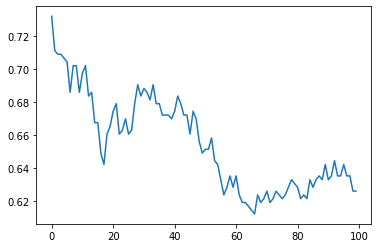

In [29]:
error_rates = []

for i in np.arange(1, 101):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train1)
    model1 = KNeighborsClassifier(n_neighbors = 5)
    model1.fit(X_train, y_train1)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test1))

plt.plot(error_rates);

In [30]:
# feature_selection_model1 = KNeighborsClassifier(n_neighbors = np.argmin(error_rates))
feature_selection_model1 = KNeighborsClassifier(n_neighbors = 10)

In [32]:
y_train1

20      0
21      0
22      3
23      1
24      3
       ..
1973    1
1974    0
1975    1
1977    1
1978    1
Name: expected_target1, Length: 1730, dtype: int64

In [37]:
sfs1 = SFS(feature_selection_model1,
          k_features=200,
          forward=True, 
          floating=False, 
          scoring='accuracy', 
          verbose=1,
          cv=5, 
          n_jobs=-1)

sfs1 = sfs1.fit(X_train, y_train1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    2.4s finished
Features: 1/200[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    2.6s finished
Features: 2/200[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 221 out of 232 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    2.8s finished
Features: 3/200[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 231 out of 231 | elapsed:    2.8s finished
Features: 4/200[Parallel(n_jobs=-1)]: 

## Main model

In [29]:
y_train1 = pd.get_dummies(y_train1)
y_test1 = pd.get_dummies(y_test1)

In [30]:
y_train1, y_test1 = make_equal_dummies(y_train1, y_test1)

(433, 9) (1730, 9)


In [31]:
batch_size = 32
epochs = 150

In [32]:
num_classes = train_df['expected_target1'].nunique()
model1 = create_model(batch_size, epochs, num_classes, X_train.shape[1])

In [33]:
history1 = model1.fit(X_train, y_train1, 
                      batch_size = batch_size, 
                      epochs = epochs, 
                      validation_data = (X_test, y_test1),
)

Epoch 1/150
55/55 [==============================] - 2s 6ms/step - loss: 2.7812 - accuracy: 0.1301 - val_loss: 2.2770 - val_accuracy: 0.1224
Epoch 2/150
55/55 [==============================] - 0s 2ms/step - loss: 2.7662 - accuracy: 0.1214 - val_loss: 2.2889 - val_accuracy: 0.1062
Epoch 3/150
55/55 [==============================] - 0s 2ms/step - loss: 2.7267 - accuracy: 0.1254 - val_loss: 2.2863 - val_accuracy: 0.1316
Epoch 4/150
55/55 [==============================] - 0s 2ms/step - loss: 2.6477 - accuracy: 0.1231 - val_loss: 2.3074 - val_accuracy: 0.1547
Epoch 5/150
55/55 [==============================] - 0s 2ms/step - loss: 2.6469 - accuracy: 0.1422 - val_loss: 2.3185 - val_accuracy: 0.1478
Epoch 6/150
55/55 [==============================] - 0s 2ms/step - loss: 2.6153 - accuracy: 0.1538 - val_loss: 2.3189 - val_accuracy: 0.1478
Epoch 7/150
55/55 [==============================] - 0s 2ms/step - loss: 2.5402 - accuracy: 0.1694 - val_loss: 2.3182 - val_accuracy: 0.1386
Epoch 8/150
5

Epoch 59/150
55/55 [==============================] - 0s 3ms/step - loss: 1.8945 - accuracy: 0.2879 - val_loss: 1.7455 - val_accuracy: 0.3372
Epoch 60/150
55/55 [==============================] - 0s 2ms/step - loss: 1.8982 - accuracy: 0.2925 - val_loss: 1.7385 - val_accuracy: 0.3233
Epoch 61/150
55/55 [==============================] - 0s 3ms/step - loss: 1.9208 - accuracy: 0.2653 - val_loss: 1.7370 - val_accuracy: 0.3187
Epoch 62/150
55/55 [==============================] - 0s 2ms/step - loss: 1.9146 - accuracy: 0.2775 - val_loss: 1.7320 - val_accuracy: 0.3256
Epoch 63/150
55/55 [==============================] - 0s 2ms/step - loss: 1.8950 - accuracy: 0.2983 - val_loss: 1.7258 - val_accuracy: 0.3372
Epoch 64/150
55/55 [==============================] - 0s 2ms/step - loss: 1.9028 - accuracy: 0.2763 - val_loss: 1.7177 - val_accuracy: 0.3303
Epoch 65/150
55/55 [==============================] - 0s 3ms/step - loss: 1.8724 - accuracy: 0.2908 - val_loss: 1.7150 - val_accuracy: 0.3233
Epoch 

55/55 [==============================] - 0s 2ms/step - loss: 1.7197 - accuracy: 0.3121 - val_loss: 1.5731 - val_accuracy: 0.3649
Epoch 117/150
55/55 [==============================] - 0s 2ms/step - loss: 1.6980 - accuracy: 0.3133 - val_loss: 1.5768 - val_accuracy: 0.3464
Epoch 118/150
55/55 [==============================] - 0s 2ms/step - loss: 1.6834 - accuracy: 0.3347 - val_loss: 1.5713 - val_accuracy: 0.3603
Epoch 119/150
55/55 [==============================] - 0s 2ms/step - loss: 1.6854 - accuracy: 0.3329 - val_loss: 1.5705 - val_accuracy: 0.3626
Epoch 120/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7014 - accuracy: 0.3052 - val_loss: 1.5717 - val_accuracy: 0.3695
Epoch 121/150
55/55 [==============================] - 0s 2ms/step - loss: 1.6934 - accuracy: 0.3121 - val_loss: 1.5719 - val_accuracy: 0.3672
Epoch 122/150
55/55 [==============================] - 0s 2ms/step - loss: 1.6881 - accuracy: 0.3208 - val_loss: 1.5704 - val_accuracy: 0.3718
Epoch 123/150

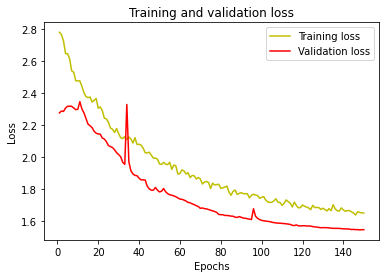

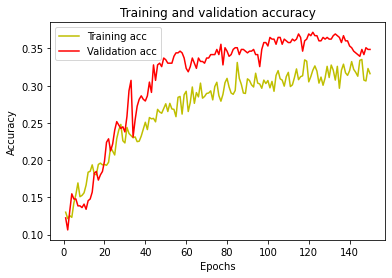

In [34]:
make_graphs(history1)

In [35]:
tmp_pred_value1 = calc_train_acc(model1, 'expected_target1', Y_expected1)

ACC:  0.774


# Model for agent2

In [36]:
y_train2 = pd.get_dummies(y_train2)
y_test2 = pd.get_dummies(y_test2)

In [37]:
y_train2, y_test2 = make_equal_dummies(y_train2, y_test2)

(433, 9) (1730, 9)


In [38]:
batch_size = 32
epochs = 150

In [39]:
num_classes = train_df['expected_target2'].nunique()
model2 = create_model(batch_size, epochs, num_classes, X_train.shape[1])

In [40]:
history2 = model2.fit(X_train, y_train2, 
                      batch_size = batch_size, 
                      epochs = epochs, 
                      validation_data = (X_test, y_test2),
)

Epoch 1/150
55/55 [==============================] - 2s 6ms/step - loss: 2.7311 - accuracy: 0.1202 - val_loss: 2.1193 - val_accuracy: 0.2956
Epoch 2/150
55/55 [==============================] - 0s 2ms/step - loss: 2.7265 - accuracy: 0.1329 - val_loss: 2.1003 - val_accuracy: 0.2679
Epoch 3/150
55/55 [==============================] - 0s 2ms/step - loss: 2.6711 - accuracy: 0.1295 - val_loss: 2.1289 - val_accuracy: 0.2564
Epoch 4/150
55/55 [==============================] - 0s 2ms/step - loss: 2.5824 - accuracy: 0.1387 - val_loss: 2.1282 - val_accuracy: 0.2286
Epoch 5/150
55/55 [==============================] - 0s 2ms/step - loss: 2.5379 - accuracy: 0.1555 - val_loss: 2.1233 - val_accuracy: 0.2379
Epoch 6/150
55/55 [==============================] - 0s 2ms/step - loss: 2.5499 - accuracy: 0.1480 - val_loss: 2.1252 - val_accuracy: 0.2240
Epoch 7/150
55/55 [==============================] - 0s 2ms/step - loss: 2.5633 - accuracy: 0.1543 - val_loss: 2.1240 - val_accuracy: 0.2333
Epoch 8/150
5

Epoch 59/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7938 - accuracy: 0.3087 - val_loss: 1.6803 - val_accuracy: 0.3303
Epoch 60/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7737 - accuracy: 0.3254 - val_loss: 1.6688 - val_accuracy: 0.3256
Epoch 61/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7927 - accuracy: 0.3329 - val_loss: 1.6643 - val_accuracy: 0.3464
Epoch 62/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7899 - accuracy: 0.3145 - val_loss: 1.6526 - val_accuracy: 0.3395
Epoch 63/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7737 - accuracy: 0.3035 - val_loss: 1.6449 - val_accuracy: 0.3418
Epoch 64/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7326 - accuracy: 0.3260 - val_loss: 1.6382 - val_accuracy: 0.3510
Epoch 65/150
55/55 [==============================] - 0s 2ms/step - loss: 1.7639 - accuracy: 0.3237 - val_loss: 1.6453 - val_accuracy: 0.3441
Epoch 

55/55 [==============================] - 0s 2ms/step - loss: 1.5592 - accuracy: 0.3462 - val_loss: 1.4935 - val_accuracy: 0.3695
Epoch 117/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5870 - accuracy: 0.3324 - val_loss: 1.5101 - val_accuracy: 0.3418
Epoch 118/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5599 - accuracy: 0.3526 - val_loss: 1.5022 - val_accuracy: 0.3487
Epoch 119/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5620 - accuracy: 0.3428 - val_loss: 1.4982 - val_accuracy: 0.3487
Epoch 120/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5530 - accuracy: 0.3457 - val_loss: 1.4946 - val_accuracy: 0.3418
Epoch 121/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5567 - accuracy: 0.3364 - val_loss: 1.4917 - val_accuracy: 0.3395
Epoch 122/150
55/55 [==============================] - 0s 2ms/step - loss: 1.5399 - accuracy: 0.3428 - val_loss: 1.4907 - val_accuracy: 0.3487
Epoch 123/150

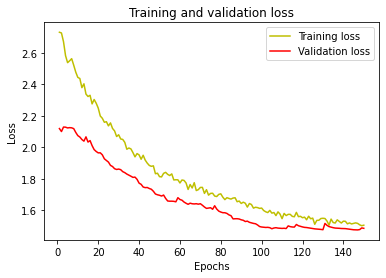

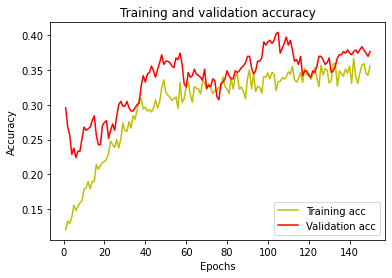

In [41]:
make_graphs(history2)

In [42]:
tmp_pred_value2 = calc_train_acc(model2, 'expected_target2', Y_expected2)

ACC:  0.619


# Test acc

In [43]:
test_pred = np.logical_and(tmp_pred_value1, tmp_pred_value2)
test_pred = [0 if x==False else x for x in test_pred]
test_pred = [1 if x==True else x for x in test_pred]

In [44]:
test_real_value = train_df['category'][int(len(Y_expected1)*0.8):len(Y_expected1)]
test_real_value

1979    0
1980    0
1981    1
1982    0
1983    0
       ..
2465    1
2466    1
2467    0
2468    1
2469    1
Name: category, Length: 433, dtype: int64

In [45]:
acc = 0
for elem1, elem2 in zip(test_pred, test_real_value):
    if elem1 == elem2:
        acc += 1
print("ACC: ", np.round((acc / len(test_real_value)), 3))

ACC:  0.547


# Make a submission

In [46]:
fin_pred1 = model1.predict(test_df)
tmp1 = []
for i in fin_pred1:
    if i.argmax() != 0:
        tmp1.append(1)
    else:
        tmp1.append(0)

print(tmp1)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 

In [47]:
fin_pred2 = model2.predict(test_df)
tmp2 = []
for i in fin_pred2:
    if i.argmax() != 0:
        tmp2.append(1)
    else:
        tmp2.append(0)

print(tmp2)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 

In [48]:
Answer = np.logical_and(tmp1, tmp2)
Answer = [0 if x==False else x for x in Answer]
Answer = [1 if x==True else x for x in Answer]

In [49]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['tmp'] = Answer
sample_submission.drop(['category'], axis = 1, inplace= True)
sample_submission = sample_submission.rename(columns={"tmp": "category"})
sample_submission.to_csv('Answer.csv', index = False)

In [50]:
sample_submission

,id,category
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1
...,...,...
565,565,0
566,566,0
567,567,1
568,568,0
